## Goal: Train a SNN on a Spiking Heidelberg Digits Dataset
Spikes in 700 input channels were generated using an artificial cochlea model listening to studio recordings of spoken digits from 0 to 9 in both German and English languages.

- __Number of classes__: 20
- __Number of train samples__: 8156
- __Number of test samples__: 2264
- __Dimensions__: [num_steps x 700]
    - __num_steps__: time-dimension of audio channels
    - __700__: number of channels in cochlea model

For further reading, see:
_Cramer, B., Stradmann, Y., Schemmel, J., and Zenke, F. (2020). The Heidelberg Spiking Data Sets for the Systematic Evaluation of Spiking Neural Networks. IEEE Transactions on Neural Networks and Learning Systems 1–14._

In [1]:
!pip install snntorch

In [2]:
import snntorch as snn
import torch, torch.nn as nn
from snntorch.spikevision import spikedata

<ipython-input-2-dbeec5575eb5>:3: DeprecationWarning: The module snntorch.spikevision is deprecated. For loading neuromorphic datasets, we recommend using the Tonic project: https://github.com/neuromorphs/tonic
  from snntorch.spikevision import spikedata


## Downlaod Dataset

In [3]:
# note that a default transform is already applied to keep things easy
train_ds = spikedata.SHD("dataset/shd", train=True)
test_ds = spikedata.SHD("dataset/shd", train=False)

In [4]:
train_ds

Dataset SHD
    Number of datapoints: 8156
    Root location: dataset/shd/shd.hdf5
    StandardTransform
Transform: Compose(
               Downsample(dt = {0}, dp = {1}, dx = {2}, dy = {3})
               ToChannelHeightWidth()
               ToCountFrame(T=1000)
               ToTensor(device:cpu)
               hflip()
           )
Target transform: <function identity at 0x7ff9199df700>

## Create DataLoaders

In [5]:
batch_size = 64
from torch.utils.data import DataLoader
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Torch Variables
dtype = torch.float 

train_dl = DataLoader(train_ds, shuffle=True, batch_size=batch_size)
test_dl = DataLoader(test_ds, shuffle=False, batch_size=batch_size)

## Play with Data

In [6]:
# get a feel for the data
test_dl.dataset[0][0].size()  #index into sample 0

torch.Size([1000, 700])

## Plot Data

torch.Size([1000, 700])


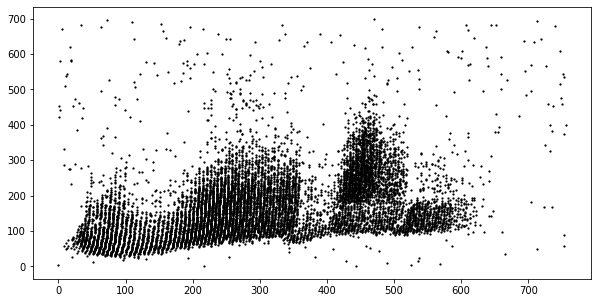

In [7]:
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt

n = 2000

print(test_dl.dataset[n][0].size())

fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)

splt.raster(test_dl.dataset[n][0], ax, s=1.5, c="black")

In [8]:
from snntorch import surrogate


beta = 0.9  # neuron decay rate 
spike_grad = surrogate.fast_sigmoid()

#  Initialize Network
#nn.Conv2d layers expect a 4-dimensional input tensor in the shape [batch_size, channels, height, width].
net = nn.Sequential(nn.Conv1d(1000, 8, 5),
                    nn.MaxPool1d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Conv1d(8, 16, 5),
                    nn.MaxPool1d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Flatten(),
                    nn.Linear(2752, 20),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
                    ).to(device)




Forward Pass

In [9]:
from snntorch import utils

def forward_pass(net, data, num_steps):
  spk_rec = []
  utils.reset(net)  # resets hidden states for all LIF neurons in net

  for step in range(num_steps):
      #data = data.unsqueeze(0)
      spk_out, mem_out = net(data)
      spk_rec.append(spk_out)
  
  return torch.stack(spk_rec)

In [10]:
import snntorch.functional as SF

optimizer = torch.optim.Adam(net.parameters(), lr=2e-3, betas=(0.9, 0.999))
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

Training Loop

In [11]:
num_epochs = 1
num_steps = 25  # run for 25 time steps 

loss_hist = []
acc_hist = []

# training loop
for epoch in range(num_epochs):
    for i, (data, targets) in enumerate(iter(train_dl)):
        data = data.to(device)
        targets = targets.to(device)

        net.train()
        spk_rec = forward_pass(net, data, num_steps)
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # print every 25 iterations
        if i % 25 == 0:
          print(f"Epoch {epoch}, Iteration {i} \nTrain Loss: {loss_val.item():.2f}")

          # check accuracy on a single batch
          acc = SF.accuracy_rate(spk_rec, targets)  
          acc_hist.append(acc)
          print(f"Accuracy: {acc * 100:.2f}%\n")
        
        # uncomment for faster termination
        # if i == 150:
        #     break

Epoch 0, Iteration 0 
Train Loss: 1.75
Accuracy: 3.12%

Epoch 0, Iteration 25 
Train Loss: 0.45
Accuracy: 10.94%



In [ ]:
def test_accuracy(data_loader, net, num_steps):
  with torch.no_grad():
    total = 0
    acc = 0
    net.eval()

    data_loader = iter(data_loader)
    for data, targets in data_loader:
      data = data.to(device)
      targets = targets.to(device)
      spk_rec = forward_pass(net, data, num_steps)

      acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
      total += spk_rec.size(1)

  return acc/total

In [ ]:
# print(f"Test set accuracy: {test_accuracy(test_dl, net, num_steps)*100:.3f}%")

KeyboardInterrupt: 